# Information Theory Measures w/ RBIG

In [101]:
import os, sys
cwd = os.getcwd()
sys.path.insert(0, f"{cwd}/../")

from scipy import stats
import numpy as np
import warnings
from time import time

# IT Measures
from rbig.information.entropy import Univariate, Multivariate, MarginalEntropy
from rbig.information.mutual_information import MutualInformation, TotalCorrelation
from rbig.rbig import RBIGKLD, RBIG, RBIGMI, entropy_marginal
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Entropy - Univariate

$$H(X)=-\int_\mathcal{X}f(x)\log f(x)dx$$




Differential entropy is not invariant under arbitrary transformations. But we can find the transformation like so:
$$
\begin{aligned}
H(ax) &= H(x) + \log(a) \\
H(Ax) &= H(x) + \log |A|
\end{aligned}$$ 

### Gaussian Distribution (1D)

In [3]:
#Parameters
n_samples = 5000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)
# Generate random normal data
mu = 0
sigma = 1
seed = 123


data_original = mu + sigma * rng.randn(n_samples, 1)

H = (1/2) * np.log(2 * np.pi * np.e * sigma**2)

print(H)

1.4189385332046727


In [4]:
# Generate random normal data
mu = 0
sigma = 1
seed = 123

norm_dist = stats.norm(loc=mu, scale=sigma)

H = norm_dist.entropy()
print(H)


n_samples = 5_000

X = norm_dist.rvs(size=n_samples, random_state=seed)

1.4189385332046727


#### Histogram Entropy

In [5]:
bins = 'auto'
correction = True

H = Univariate().histogram_entropy(X, bins, True)
print(H)

1.407400755509798


#### Kernel Density Estimation

In [6]:
kernel = 'gau'
bw = 'normal_reference'
gridsize = 50
adjust = 1
cut = 3
clip = (-np.inf, np.inf)

H = Univariate().kde_entropy(X)

print(H)

1.4241976740334739


#### K-Nearest Neighbors Estimator

In [7]:
k = 20
algorithm = 'auto'
n_jobs = 1

H = Univariate().knn_entropy(X[:, None], k=k, algorithm=algorithm, n_jobs=n_jobs)
print(H)

1.4025038850034388


#### Parameters

For k-Nearest Neighbors I have the following:

* K-Neighbors

Below we'll show a small experiment where we see how the number of neighbors affects our entropy calculation.

In [8]:
hs = list()

for ik in np.linspace(5, 30, 25, endpoint=True, dtype=int):
    
    algorithm = 'auto'
    n_jobs = 1

    H = Univariate().knn_entropy(X[:, None], k=ik, algorithm=algorithm, n_jobs=n_jobs)
    
    hs.append(H)
    

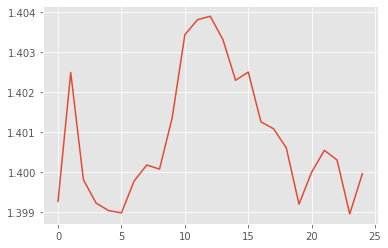

In [9]:
plt.plot(hs)

10 seems to be a good number for this 1D problem.

### Exponential Family

## Entropy - Multivariate

### Gaussian (2D)

In [106]:
# Generate random normal data
mean = np.array([0, 1., 10])
cov = np.array([0.3, 0.9, 0.1])
seed = 123

mvn_dist = stats.multivariate_normal(mean=mean, cov=cov, seed=seed)

H = mvn_dist.entropy()
print(H)


n_samples = 5_000

X = mvn_dist.rvs(size=n_samples, random_state=seed)

X.shape

2.4508563931251146


(5000, 3)

#### Assume Gaussian

In [77]:
mean = X.mean(axis=0)
cov = np.cov(X.T)

# assume it's a Gaussian
X_norm = stats.multivariate_normal(mean=mean, cov=cov, seed=seed)

H_gauss = X_norm.entropy()
print(H)

2.4508563931251146


#### Assume Gaussian

In [78]:
H_gauss = Multivariate().gaussian(X)

print(H_gauss)

2.4471819361480556


#### Exponential Family

In [79]:
H_expF = Multivariate().expF_entropy(X)

np.testing.assert_allclose(H_gauss, H_expF)

print(H_expF)

2.4471819361481266


#### K-NN

In [80]:
k = 20
algorithm = 'auto'
n_jobs = 1

H = Multivariate().knn_entropy(X, k=k, algorithm=algorithm, n_jobs=n_jobs)
print(H)

2.407725442833219


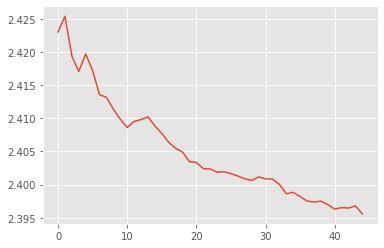

In [81]:
hs = list()

for ik in np.linspace(5, 50, 45, endpoint=True, dtype=int):
    
    algorithm = 'auto'
    n_jobs = 1

    H = Multivariate().knn_entropy(X, k=ik, algorithm=algorithm, n_jobs=n_jobs)
    
    hs.append(H)
plt.plot(hs)

### Rotated Gaussian 2D

In [117]:
A = rng.rand(X.shape[1], X.shape[1])

Ax = X @ A

# entropy of rotated distribution
Hx = MarginalEntropy('gauss').entropy(X)

H_A = np.log(np.abs(np.linalg.det(A)))
H_Ax = Hx.sum() + H_A

print(H)

2.3955852776660604


#### Assume Gaussian

In [118]:
H_gauss = Multivariate().gaussian(Ax)


print(H_gauss)

-0.5753722853670853


#### Exponential Family

In [119]:
H_expF = Multivariate().expF_entropy(Ax)

print(H_expF)

-0.575372285366484


#### K-Nearest Neighbors Estimator

In [120]:
k = 20
algorithm = 'auto'
n_jobs = 1

H = Multivariate().knn_entropy(X, k=k, algorithm=algorithm, n_jobs=n_jobs)
print(H)

2.407725442833219


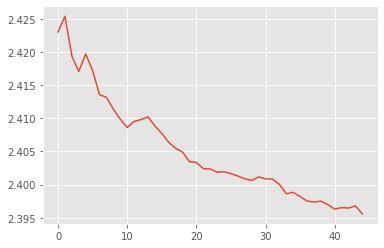

In [121]:
hs = list()

for ik in np.linspace(5, 50, 45, endpoint=True, dtype=int):
    
    algorithm = 'auto'
    n_jobs = 1

    H = Multivariate().knn_entropy(X, k=ik, algorithm=algorithm, n_jobs=n_jobs)
    
    hs.append(H)
plt.plot(hs)

## Mutual Information (X,Y)

### Gaussian Distribution (1D)

In [96]:
#Parameters
n_samples = 10000
d_dimensions = 1

seed = 123

rng = check_random_state(seed)

# Generate random Data
A = rng.rand(2 * d_dimensions, 2 * d_dimensions)

# Covariance Matrix
C = A @ A.T
mu = np.zeros((2 * d_dimensions))

dat_all = rng.multivariate_normal(mu, C, n_samples)

CX = C[:d_dimensions, :d_dimensions]
CY = C[d_dimensions:, d_dimensions:]

X = dat_all[:, :d_dimensions]
Y = dat_all[:, d_dimensions:]

In [97]:
H_X = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CX)))
H_Y = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CY)))
H = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(C)))

mi_original = H_X + H_Y - H
mi_original *= np.log(2)

print(f"MI: {mi_original:.4f}")

MI: 1.2202


#### K-Nearest Neighbors Estimator

In [98]:
kwargs = {'n_neighbors': 10}
mi = MutualInformation("knn", kwargs).fit(X, Y)

print(mi.MI)

Marginal: 1.1487551678194339
Marginal: 0.8961816910448888
Full: 1.6909694209301258
0.3539674379341968


In [80]:
np.hstack([X,Y]).shape

(10000, 2)

In [81]:
kwargs = {'n_neighbors': 10}
mi = TotalCorrelation("knn", kwargs).fit(np.hstack([X,Y]))

print(mi.MI)

Full: 1.6909694209301258
Marginal: 1.1487551678194339
Marginal: 0.8961816910448888
0.3539674379341968


In [77]:
1.1487551 + 0.8961816 - 1.690969

0.3539677000000001

---
## Total Correlation

In [2]:
#Parameters
n_samples = 10000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

#### Sample Data

In [3]:
# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = np.diag(C)

#### Calculate Total Correlation

In [4]:
tc_original = np.log(np.sqrt(vv)).sum() - 0.5 * np.log(np.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 9.9326


### RBIG - TC

In [5]:
%%time 
n_layers = 10000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = 10
pdf_resolution = None
tolerance = None

# Initialize RBIG class
tc_rbig_model = RBIG(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance,
                  pdf_extension=pdf_extension,
                  pdf_resolution=pdf_resolution)

# fit model to the data
tc_rbig_model.fit(data);

CPU times: user 1min 19s, sys: 64.4 ms, total: 1min 19s
Wall time: 3.01 s


In [6]:
tc_rbig = tc_rbig_model.mutual_information * np.log(2)
print(f"TC (RBIG): {tc_rbig:.4f}")
print(f"TC: {tc_original:.4f}")

TC (RBIG): 9.9398
TC: 9.9326


---
## Entropy

#### Sample Data

In [7]:
Hx = entropy_marginal(data)

# nats
H_original = Hx.sum() + np.linalg.slogdet(A)[1]

# bits
H_original *= np.log(2)

print(f"H: {H_original:.4f}")

#### Calculate Entropy

In [8]:
Hx = entropy_marginal(data)

H_original = Hx.sum() + np.log2(np.abs(np.linalg.det(A)))

H_original *= np.log(2)

print(f"H: {H_original:.4f}")

H: 16.4355


### Entropy RBIG

In [9]:
%%time 
n_layers = 10000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = None
pdf_resolution = None
tolerance = None

# Initialize RBIG class
ent_rbig_model = RBIG(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance)

# fit model to the data
ent_rbig_model.fit(data);

CPU times: user 53.1 s, sys: 9.81 ms, total: 53.1 s
Wall time: 1.9 s


In [10]:
H_rbig = ent_rbig_model.entropy(correction=True) * np.log(2)
print(f"Entropy (RBIG): {H_rbig:.4f}")
print(f"Entropy: {H_original:.4f}")

Entropy (RBIG): 10.6551
Entropy: 16.4355


---
## Mutual Information

#### Sample Data

In [11]:
#Parameters
n_samples = 10000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random Data
A = rng.rand(2 * d_dimensions, 2 * d_dimensions)

# Covariance Matrix
C = A @ A.T
mu = np.zeros((2 * d_dimensions))

dat_all = rng.multivariate_normal(mu, C, n_samples)

CX = C[:d_dimensions, :d_dimensions]
CY = C[d_dimensions:, d_dimensions:]

X = dat_all[:, :d_dimensions]
Y = dat_all[:, d_dimensions:]

#### Calculate Mutual Information

In [12]:
H_X = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CX)))
H_Y = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CY)))
H = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(C)))

mi_original = H_X + H_Y - H
mi_original *= np.log(2)

print(f"MI: {mi_original:.4f}")

MI: 8.0713


### RBIG - Mutual Information

In [13]:
%%time 
n_layers = 10000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
tolerance = None

# Initialize RBIG class
rbig_model = RBIGMI(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance)

# fit model to the data
rbig_model.fit(X, Y);

CPU times: user 5min 37s, sys: 103 ms, total: 5min 38s
Wall time: 12.1 s


In [14]:
H_rbig = rbig_model.mutual_information() * np.log(2)

print(f"MI (RBIG): {H_rbig:.4f}")
print(f"MI: {mi_original:.4f}")

MI (RBIG): 9.0746
MI: 8.0713


---
## Kullback-Leibler Divergence (KLD)

#### Sample Data

In [15]:
#Parameters
n_samples = 10000
d_dimensions = 10
mu = 0.4          # how different the distributions are

seed = 123

rng = check_random_state(seed)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

# covariance matrix
cov = A @ A.T

# Normalize cov mat
cov = A / A.max()

# create covariance matrices for x and y
cov_x = np.eye(d_dimensions)
cov_y = cov_x.copy()

mu_x = np.zeros(d_dimensions) + mu
mu_y = np.zeros(d_dimensions)

# generate multivariate gaussian data
X = rng.multivariate_normal(mu_x, cov_x, n_samples)
Y = rng.multivariate_normal(mu_y, cov_y, n_samples)


#### Calculate KLD

In [16]:
kld_original = 0.5 * ((mu_y - mu_x) @ np.linalg.inv(cov_y) @ (mu_y - mu_x).T +
                      np.trace(np.linalg.inv(cov_y) @ cov_x) -
                      np.log(np.linalg.det(cov_x) / np.linalg.det(cov_y)) - d_dimensions)

print(f'KLD: {kld_original:.4f}')

KLD: 0.8000


### RBIG - KLD

In [19]:
X.min(), X.max()

(-4.006934109277744, 4.585027222023813)

In [20]:
Y.min(), Y.max()

(-4.607129910785054, 4.299322691460413)

In [17]:
%%time

n_layers = 100000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
tolerance = None
pdf_extension = 10
pdf_resolution = None
verbose = 0

# Initialize RBIG class
kld_rbig_model = RBIGKLD(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance,
                     pdf_resolution=pdf_resolution,
                    pdf_extension=pdf_extension,
                    verbose=verbose)

# fit model to the data
kld_rbig_model.fit(X, Y);

CPU times: user 5min 46s, sys: 10.9 ms, total: 5min 46s
Wall time: 12.4 s


In [18]:
# Save KLD value to data structure
kld_rbig= kld_rbig_model.kld*np.log(2)

print(f'KLD (RBIG): {kld_rbig:.4f}')
print(f'KLD: {kld_original:.4f}')

KLD (RBIG): 0.8349
KLD: 0.8000
